In [3]:
from IPython.display import Image
from IPython.core.display import HTML 

import warnings
warnings.filterwarnings('ignore')

+ flaskのコードの意味などを詳細に

## [DSO] Machine Learning Seminar Vol.8
2020-09-29  
SKUE

In [59]:
Image(url="https://image.yodobashi.com/product/100/000/009/002/935/105/100000009002935105_10204.jpg")

# 機械学習の適用2 - Webアプリケーション
この章で行うこと
+ 訓練済みの機械学習モデルの保存
+ SQLiteの活用
+ Flaskを用いたWebアプリケーションの開発
+ モデルのデプロイ

## 学習済みのscikit-learnの推定器をシリアライズする
+ モデルの学習には時間がかかるため、pickleモジュールを用いてモデルの永続化をする。
+ pickleで保存してしまえば、予測したいときにモデルをリロードするだけで済む。

### 1.モデルやデータの保存
第8章で扱ったアウトオブコア学習の結果（stopワード(stop)、分類器(clf)）をpickleで保存しておく。

In [1]:
# import pickle
# import os
# dest = os.path.join('movieclassfier', 'pkl_objects')

# if not os.path.exists(dest):
#     os.makedirs(dest)
    
# pickle.dump(stop,
#                        open(os.path.join(dest, 'stopwords.pkl'), 'wb'),
#                        protocol=4)

# pickle.dump(clf,
#                        open(os.path.join(dest, 'classifier.pkl'), 'wb'),
#                        protocol=4)

## Tips
+ %%file  
%%fileをjypyter notebookのセルで使えばjupyter notebookで.pyファイルを生成できる。  

+ !mkdir  
Linuxコマンドのmkdirを用いてディレクトリを生成できる。

### 2.予測に必要な関数の作成
テキストのベクトル化の関数を予測を行うディレクトリに設けておく。

In [2]:
%%file movieclassfier/vectorizer.py

from sklearn.feature_extraction.text import HashingVectorizer
import re
import os
import pickle

cur_dir = os.path.dirname(__file__)
stop = pickle.load(open(os.path.join(cur_dir,
                                            'pkl_objects',
                                            'stopwords.pkl'), 'rb'))

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + '  '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop ]
    return tokenized

vect = HashingVectorizer(decode_error='ignore',
                                            n_features=2**21,
                                            preprocessor=None,
                                            tokenizer=tokenizer)

Writing movieclassfier/vectorizer.py


### 3.実行
movieclassfierのディレクトリ下でpythonを立ち上げて以下のコードを実行する。

In [3]:
# import pickle
# import re
# import os
# from vectorizer import vect
# clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))


# import numpy as np
# label = {0:'negative',
#               1:'positive'}

# example = ['I love this movie'] # これが新しいデータ
# X = vect.transform(example) # 前処理
# print('Prediction: %s\nProbability: %.2f%%' \
#       %(label[clf.predict(X)[0]],np.max(clf.predict_proba(X))*100)) # 学習済みモデルでの予測

## データストレージとしてSQLiteデータベースを設定する
+ SQLiteとは
 + OSSのSQLデータベース
 + サーバは用意しなくてもいい。
 + 全てが1つのファイルに含まれたデータベースと考えることができる。
 + sqlite3として、Pythonの標準ライブラリになっている。

### 1.SQLiteでDBのテーブル作成とレコード追加
以下のコードを実行して、テーブルを生成して、レコードを2件追加する。  
SQLiteのデータは.sqliteの拡張子で保存される。  
ここではreviews.sqliteを都度、消して入れ直すという書き方をしている。

In [7]:
import sqlite3
import os

if os.path.exists('reviews.sqlite'):
    os.remove('reviews.sqlite')
    
conn = sqlite3.connect('reviews.sqlite') # パスワードとかなしでアクセスできる。
c = conn.cursor() # cursorオブジェクトはSQLを実行できる環境を提供してくれる。
c.execute('CREATE TABLE review_db (review TEXT, sentiment INTEGER, date TEXT) ')
example1 = 'I love this movie' # 新しいデータ
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES"\
                     "(?, ?, DATETIME('now'))", (example1, 1)) # データのDBの特定テーブルへの挿入

example2 = 'I disliked this movie' # 新しいデータ
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES"\
                     "(?, ?, DATETIME('now'))", (example2, 0)) # データのDBの特定テーブルへの挿入
conn.commit() # これを実行しないと実行内容が保存されない。
conn.close() # 接続しっぱなしになるので閉じる。

### 2.保存したデータの読み込み
以下のコードでSQLiteに保存したデータを読み込むことができる。

In [8]:
conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()
c.execute("SELECT * FROM review_db WHERE date"\
                   " BETWEEN '2017-01-01 00:00:00' AND DATETIME('now') ")
results = c.fetchall()
conn.close()
print(results)

[('I love this movie', 1, '2020-09-19 08:27:24'), ('I disliked this movie', 0, '2020-09-19 08:27:24')]


## Flaskを使ってWebアプリケーションを開発する
+ Flaskとは
 + 軽量なWebアプリケーションのフレームワーク

In [10]:
# インストールする
# !pip install flask

### "Hello World!"的な試行1：htmlをブラウザで表示する
+ その1：ディレクトリを作る
+ その2：app.pyというwebアプリケーションをつかさどるファイルを作る
+ その3：webアプリケーションで表示したいhtmlファイルを作る

In [12]:
# ディレクトリを作っておく
# !mkdir 1st_flask_app_1

In [14]:
# ディレクトリを作っておく
# !mkdir 1st_flask_app_1/templates

webアプリケーションをつかさどるファイルを作る

In [15]:
%%file 1st_flask_app_1/app.py

from flask import Flask, render_template

app = Flask(__name__) # 初期化して、テンプレが同じディレクトリ内で見つかるようにしている。
@app.route('/') # インデックス関数が実行すべきURLを指定している。

def index():
    return render_template('first_app.html') # レンダリング

if __name__ == '__main__':
    app.run() # サーバ上のアプリケーションを実行

Writing 1st_flask_app_1/app.py


webアプリケーションで表示したいhtmlファイルを作る

In [17]:
%%file 1st_flask_app_1/templates/first_app.html
<!doctype html>
<html>
    <head>
        <title>First app</title>
    </head>
        <div>Hi, this is my first Flaskweb app!</div>
    </body>
</html>

Overwriting 1st_flask_app_1/templates/first_app.html


python app.py  
をターミナルで実行してローカルサーバーのアドレス（ http://127.0.0.1:5000/ ）が表示されるので、それをwebブラウザで開くなどすればいい。  

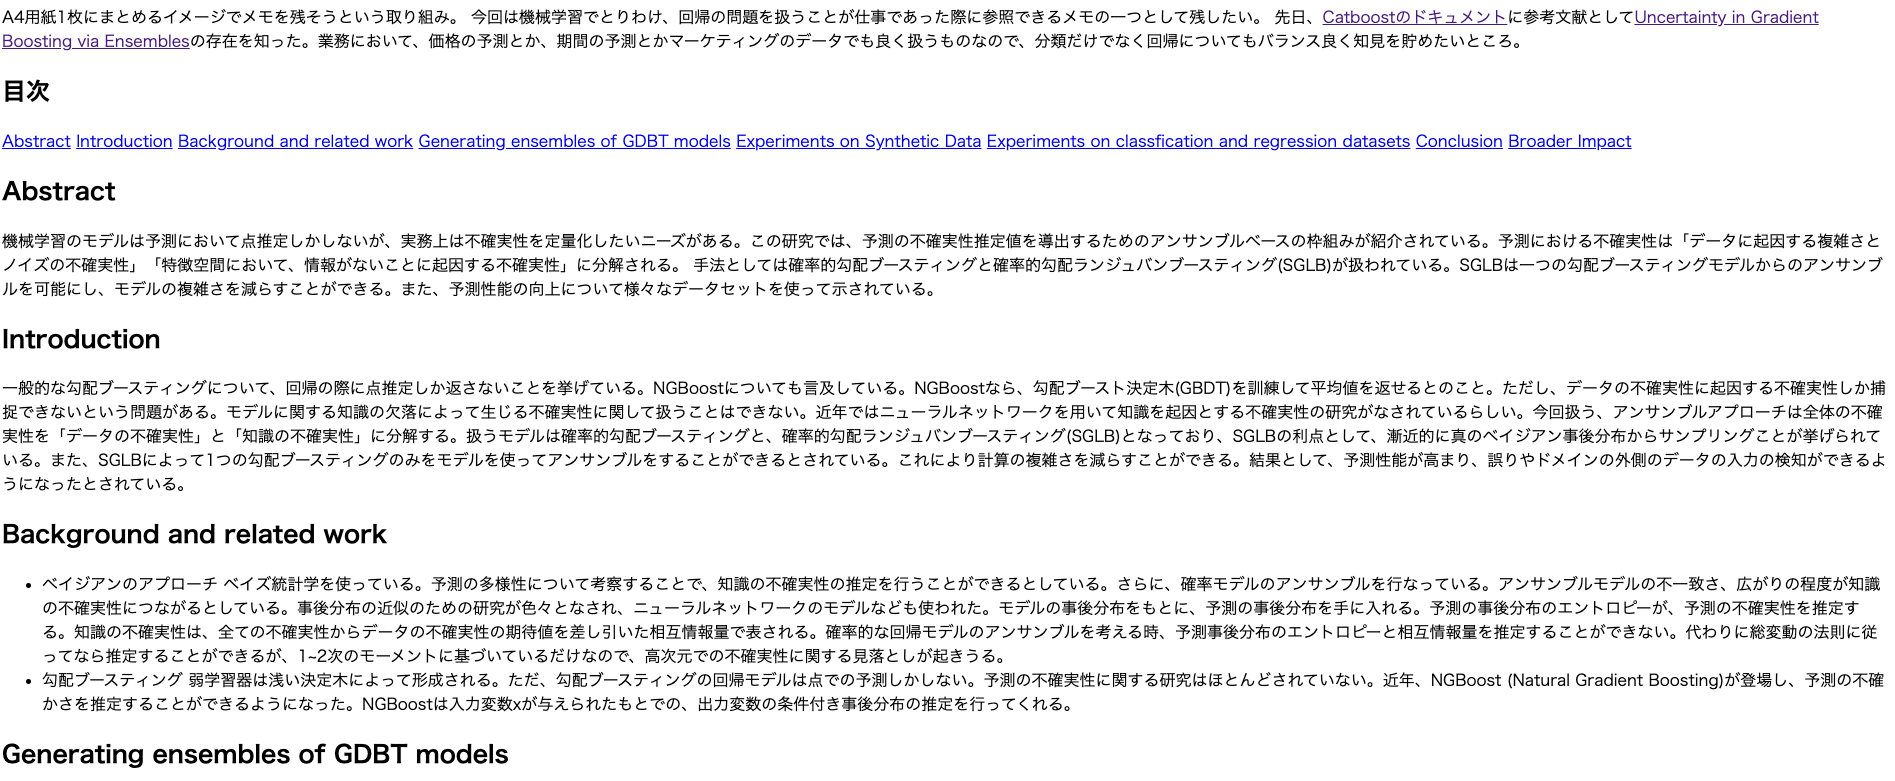

In [4]:
Image('1st_flask_app_1/flask_test1.png')

### "Hello World!"的な試行2：webフォームからデータを集める
+ その1：WTFormsライブラリでユーザからデータを収集する
+ その2：ディレクトリを作る
+ その3：app.pyというwebアプリケーションをつかさどるファイルを作る
+ その4：Jinja2というテンプレートエンジンを用いてhtml周りの処理をさせる。
 + Jinja2はテキストベースのテンプレートエンジンで、HTMLやXMLだけでなく、どのようなマークアップの文書でも生成できる。
+ その5：cssを使ってスタイルを追加する
+ その6：webアプリケーションで表示したいhtmlファイルを作る

In [20]:
# wtformsをインストール
# !pip install wtforms

In [21]:
# ディレクトリを作っておく
# !mkdir 1st_flask_app_2

In [23]:
# ディレクトリを作っておく
# !mkdir 1st_flask_app_2/static

In [24]:
# ディレクトリを作っておく
# !mkdir 1st_flask_app_2/templates

app.pyというwebアプリケーションをつかさどるファイルを作る

In [30]:
%%file 1st_flask_app_2/app.py
from flask import Flask, render_template, request
from wtforms import Form, TextAreaField, validators

app = Flask(__name__)

class HelloForm(Form):
    sayhello = TextAreaField(' ', [validators.DataRequired()]) # テキストフィールドの拡張

@app.route('/') # フォーム画面での挙動
def index():
    form = HelloForm(request.form)
    return render_template('first_app.html', form=form)

@app.route('/hello', methods=['POST']) # 入力後のページでの挙動
def hello():
    form = HelloForm(request.form)
    if request.method == 'POST' and form.validate(): # POSTメソッドを使ってフォームのデータをサーバに送信する。
        name = request.form['sayhello'] # 受け取った名前のデータ
        return render_template('hello.html', name=name) # 受け取った名前のデータをhtmlに反映する。
    return render_template('first_app.html', form=form)

if __name__ == '__main__':
    app.run(debug=True)

Overwriting 1st_flask_app_2/app.py


Jinja2というテンプレートエンジンを用いてhtml周りの処理をさせる。

In [35]:
%%file 1st_flask_app_2/templates/_formhelpers.html

{% macro render_field(field) %}
    <dt>{{ field.label  }}
    <dd>{{ field(**kwargs) | safe }}
    {% if field.errors %}
        <ul class=errors>
        {% for error in field.errors %}
            <li>{{  error  }}</li>
        {% endfor %}
        </ul>
    {% endif %}
    </dd>
    </dt>
{% endmacro %}

Writing 1st_flask_app_2/templates/_formhelpers.html


cssを使ってスタイルを追加する。ここではフォントの大きさを指定しているだけ。

In [36]:
%%file 1st_flask_app_2/static/style.css

body{
    font-size: 2em;
}

Overwriting 1st_flask_app_2/static/style.css


### webアプリケーションで表示したいhtmlファイルを作る
これは入力画面。_formhelpers.htmlというjinjaのファイルを呼び出してレンダリングをしている。  
※レンダリングとは、データなどで保持している情報から、コンピュータのプログラムを用いて画像などを生成すること。

In [37]:
%%file 1st_flask_app_2/templates/first_app.html
<!doctype html>
<html>
    <head>
        <titile>First app</title>
        <link rel="stylesheet"
                    href="{{ url_for('static', filename='style.css')}}">
    </head>
    <body>
    {% from "_formhelpers.html" import render_field %}
    
    <div>Whats your name?</div>
    <form method=post action="/hello">
        <dl>
            {{ render_field(form.sayhello) }}
        </dl>
        <input type=submit value='Say Hello' name='submit_btn'>
    </form>
    </body>
</html>

Overwriting 1st_flask_app_2/templates/first_app.html


これはフォーム入力後のページ。受け取った名前を画面に表示するためのコード。

In [38]:
%%file 1st_flask_app_2/templates/hello.html
<!doctype html>
<html>
    <head>
        <titile>First app</title>
        <link rel="stylesheet"
                    href="{{ url_for('static', filename='style.css')}}">
    </head>
    <body>
        <div>Hello {{ name }}</div>
    </body>
</html>

Overwriting 1st_flask_app_2/templates/hello.html


python app.py  
をターミナルで実行してローカルサーバーのアドレス（ http://127.0.0.1:5000/ ）が表示されるので、それをwebブラウザで開くなどすればいい。  

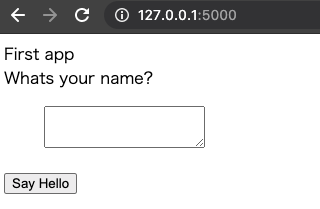

In [5]:
Image('1st_flask_app_2/flask_test2_1.png')

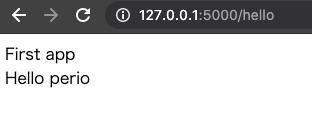

In [6]:
Image('1st_flask_app_2/flask_test2_2.png')

## 映画レビュー分類器をWebアプリケーションとして実装する
+ その1：ディレクトリを作る
+ その2：update.pyという映画レビューの分類器の更新をつかさどるファイルを作成する
+ その3：app.pyというwebアプリケーションをつかさどるファイルを作る
+ その4：Jinja2を用いてhtml周りの処理をさせる
+ その5：cssを使ってスタイルを追加する
+ その6：webアプリケーションで表示したいhtmlファイルを作る

In [ ]:
# なければこれでディレクトリを作る
# !mkdir movieclassfier

In [43]:
# ディレクトリを作る
# !mkdir movieclassfier/templates

In [47]:
# ディレクトリを作る
# !mkdir movieclassfier/static

update.pyという映画レビューの分類器の更新をつかさどるファイルを作成する

In [56]:
%%file movieclassfier/update.py
import pickle
import sqlite3
import numpy as np
import os
from vectorizer import vect # ローカルディレクトリからHashingVectorizerをインポート

def update_model(db_path, model, batch_size=10000):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute('SELECT * from review_db')    
    results = c.fetchmany(batch_size)
    while results:
        data = np.array(results)
        X = data[:, 0]
        y = data[:, 1].astype(int)
        classes = np.array([0, 1])
        X_train = vect.transform(X) # 前処理
        model.partial_fit(X_train, y, classes=classes) # 学習
        results = c.fetchmany(batch_size)        
    conn.close()
    return model

cur_dir = os.path.dirname(__file__)
clf = pickle.load(open(os.path.join(cur_dir, 'pkl_objects', 'classifier.pkl'), 'rb'))
db = os.path.join(cur_dir, 'reviews.sqlite')
clf = update_model(db_path=db, model=clf, batch_size=10000)
# classifier.pklのファイルを永続的に更新したい場合は以下のコードのコメントを解除
# pickle.dump(clf, open(os.path.join(cur_dir, 'pkl_objects', 'classifier.pkl'), 'wb'), protocol=4)

Overwriting movieclassfier/update.py


app.pyというwebアプリケーションをつかさどるファイルを作る

In [57]:
%%file movieclassfier/app.py

from flask import Flask, render_template, request
from wtforms import Form, TextAreaField, validators
import pickle
import sqlite3
import os
import numpy as np

# ローカルディレクトリからHashingVectorizerをインポート
from vectorizer import vect

# ローカルディレクトリからupdate関数をインポート
from update import update_model

app = Flask(__name__)

####### 分類器の準備
cur_dir = os.path.dirname(__file__)
clf = pickle.load(open(os.path.join(cur_dir, 'pkl_objects', 'classifier.pkl'), 'rb'))
db = os.path.join(cur_dir, 'reviews.sqlite')

def classify(document):
    label = {0: 'negative',
                  1: 'positive'}
    X = vect.transform([document])
    y = clf.predict(X)[0]
    proba = clf.predict_proba(X).max()
    return label[y], proba

def train(document, y):
    X = vect.transform([document])
    clf.partial_fit(X, [y])
    
def sqlite_entry(path, document, y):
    conn = sqlite3.connect(path)
    c = conn.cursor()
    c.execute("INSERT INTO review_db (review, sentiment, date)"\
                        " VALUES (?, ?, DATETIME('now'))", (document, y))
    conn.commit()
    conn.close()
    
    
###### Flask
class ReviewForm(Form):
    moviereview = TextAreaField(' ',
                                                           [validators.DataRequired(),
                                                               validators.length(min=15)]) # レビューは15文字以内
    
@app.route('/')
def index():
    form = ReviewForm(request.form)
    return render_template('reviewform.html', form=form)

@app.route('/requests', methods=['POST'])
def results():
    form = ReviewForm(request.form)
    if request.method == 'POST' and form.validate():
        review = request.form['moviereview']
        y, proba = classify(review)
        return render_template('results.html',
                                                  contents=review,
                                                  prediction=y,
                                                  probability=round(proba*100, 2))
    return render_template('reviewform.html', form=form)

@app.route('/thanks', methods=['POST'])
def feedback():
    feedback = request.form['feedback_button']
    review = request.form['review']
    prediction = request.form['prediction']
    
    inv_label = {'negative':0,
                          'positive':1}
    y = inv_label[prediction]
    if feedback == 'Incorrect':
        y = int(not(y))
    train(review, y)
    sqlite_entry(db, review, y)
    return render_template('thanks.html')

if __name__ == '__main__':
    clf = update_model(db_path=db, model=clf, batch_size=10000)
    app.run(debug=True)

Overwriting movieclassfier/app.py


関数が長いので分割して紹介1

In [ ]:
# %%file movieclassfier/app.py
# from flask import Flask, render_template, request
# from wtforms import Form, TextAreaField, validators
# import pickle
# import sqlite3
# import os
# import numpy as np

# # ローカルディレクトリからHashingVectorizerをインポート
# from vectorizer import vect

# # ローカルディレクトリからupdate関数をインポート
# from update import update_model

# app = Flask(__name__)

関数が長いので分割して紹介2

In [ ]:
# ####### 分類器の準備の部分の記述
# cur_dir = os.path.dirname(__file__) # 現在のディレクトリの情報を取得
# clf = pickle.load(open(os.path.join(cur_dir, 'pkl_objects', 'classifier.pkl'), 'rb')) # モデルを取得
# db = os.path.join(cur_dir, 'reviews.sqlite') # データベースの情報を取得

# def classify(document): # 分類器の関数
#     label = {0: 'negative',
#                   1: 'positive'}
#     X = vect.transform([document]) # 前処理
#     y = clf.predict(X)[0] # 予測
#     proba = clf.predict_proba(X).max() # クラスごとの確率の最大値を返す
#     return label[y], proba # ラベルと確率を返す

# def train(document, y): # 新しいデータでの訓練
#     X = vect.transform([document])
#     clf.partial_fit(X, [y]) 
    
# def sqlite_entry(path, document, y): # SQLiteにデータをインサートする関数
#     conn = sqlite3.connect(path)
#     c = conn.cursor()
#     c.execute("INSERT INTO review_db (review, sentiment, date)"\
#                         " VALUES (?, ?, DATETIME('now'))", (document, y))
#     conn.commit()
#     conn.close()

関数が長いので分割して紹介3

In [ ]:
# ###### Flask部分の記述1
# class ReviewForm(Form):
#     moviereview = TextAreaField(' ',
#                                                            [validators.DataRequired(),
#                                                                validators.length(min=15)]) # レビューは15文字以内
    
# @app.route('/') # トップページの挙動に関する記述
# def index():
#     form = ReviewForm(request.form)
#     return render_template('reviewform.html', form=form)

# @app.route('/requests', methods=['POST']) # 結果ページの挙動に関する記述
# def results():
#     form = ReviewForm(request.form)
#     if request.method == 'POST' and form.validate():
#         review = request.form['moviereview'] # 映画のレビューを受け取る
#         y, proba = classify(review) # レビューのデータをつっこんで、前処理させて予測
#         return render_template('results.html', # 結果をhtmlファイルに反映させる。（レンダリングする）
#                                                   contents=review,
#                                                   prediction=y,
#                                                   probability=round(proba*100, 2))
#     return render_template('reviewform.html', form=form) # 入力フォーム

関数が長いので分割して紹介4

In [ ]:
# ###### Flask部分の記述2
# @app.route('/thanks', methods=['POST']) # サンキューページの挙動に関する記述
# def feedback():
#     feedback = request.form['feedback_button']
#     review = request.form['review']
#     prediction = request.form['prediction']
    
#     inv_label = {'negative':0,
#                           'positive':1}
#     y = inv_label[prediction]
#     if feedback == 'Incorrect': # フィードバック結果によって表示を変える
#         y = int(not(y))
#     train(review, y) # モデルを訓練し直す
#     sqlite_entry(db, review, y) # 訓練データとして追加する
#     return render_template('thanks.html') # サンキューページを表示する

関数が長いので分割して紹介5

In [ ]:
# main部分の記述
# if __name__ == '__main__':
#     clf = update_model(db_path=db, model=clf, batch_size=10000) # モデルを更新してから実行する
#     app.run(debug=True)

Jinja2というテンプレートエンジンを用いてhtml周りの処理をさせる

In [52]:
%%file movieclassfier/templates/_formhelpers.html

{% macro render_field(field) %}
    <dt>{{ field.label  }}
    <dd>{{ field(**kwargs) | safe }}
    {% if field.errors %}
        <ul class=errors>
        {% for error in field.errors %}
            <li>{{  error  }}</li>
        {% endfor %}
        </ul>
    {% endif %}
    </dd>
    </dt>
{% endmacro %}

Writing movieclassfier/templates/_formhelpers.html


cssを使ってスタイルを追加する、ここでは幅とパディングについてだけ。

In [48]:
%%file movieclassfier/static/style.css

body{
    width:600px;
}
.button{
    padding-top: 20px;
}

Writing movieclassfier/static/style.css


webアプリケーションで表示したいhtmlファイルを作る。  
これは入力画面のhtml。

In [50]:
%%file movieclassfier/templates/reviewform.html
<!doctype html>
<html>
    <head>
        <link rel="stylesheet"
                    href="{{ url_for('static', filename='style.css')}}">
    </head>
    <body>
        <h2>Please enter your movie review:</h2>
        
        {% from "_formhelpers.html" import render_field %}
        
        <form method=post action="/requests">
            <dl>
                {{  render_field(form.moviereview, cols='30', rows='10') }}
            </dl>
            <div>
                <input type=submit value='Submit review' name='submit_btn'>
            </div>
        </form>
    </body>
</html>

Overwriting movieclassfier/templates/reviewform.html


これは結果の画面のhtml

In [49]:
%%file movieclassfier/templates/results.html
<!doctype html>
<html>
    <head>
        <titile>Movie Classification</title>
        <link rel="stylesheet"
                    href="{{ url_for('static', filename='style.css')}}">
    </head>
    <body>
        <h3>Your movie review:</h3>
            <div>{{ content }}</div>
        <h3>Prediction</h3>
            <div>This movie review is <strong>{{ prediction }}</strong>
                (probability: {{ probability }}%).</div>
            <div id='button'>
                <form action="/thanks" method="post">
                    <input type=submit value='Correct' name='feedback_button'>
                    <input type=submit value='Incorrect' name='feedback_button'>
                    <input type=hidden value='{{ prediction }}' name='prediction'>
                    <input type=hidden value='{{ content }}' name='review'>
                </form>
            </div>
            <div id='button'>
                <form action="/">
                    <input type=submit value='Submit another review'>
                </form>
            </div>
    </body>
</html>

Overwriting movieclassfier/templates/results.html


これはサンキューページのhtml

In [51]:
%%file movieclassfier/templates/thanks.html
<!doctype html>
<html>
    <head>
        <titile>Movie Classification</title>
        <link rel="stylesheet"
                    href="{{ url_for('static', filename='style.css')}}">
    </head>
    <body>
        <h3>Thank you for your feedbacks!</h3>
            <div id='button'>
                <form action="/">
                    <input type=submit value='Submit another review'>
                </form>
            </div>
    </body>
</html>

Writing movieclassfier/templates/thanks.html


python app.py  
をターミナルで実行してローカルサーバーのアドレス（ http://127.0.0.1:5000/ ）が表示されるので、それをwebブラウザで開くなどすればいい。  

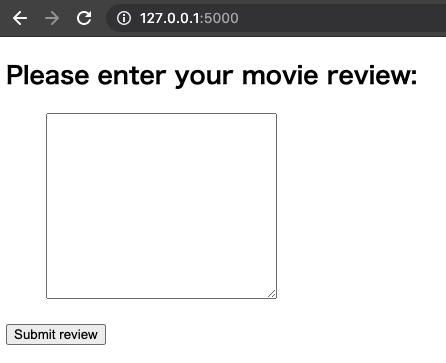

In [12]:
Image('movieclassfier/figure/flask_test1.png')

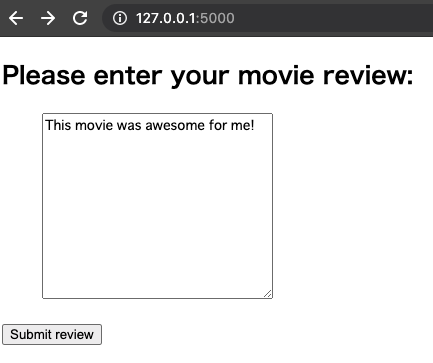

In [13]:
Image('movieclassfier/figure/flask_test2.png')

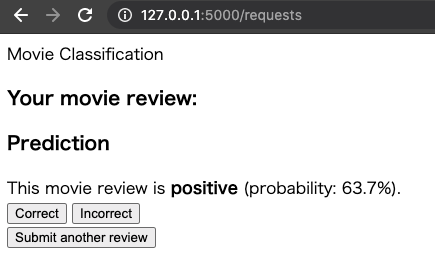

In [14]:
Image('movieclassfier/figure/flask_test3.png')

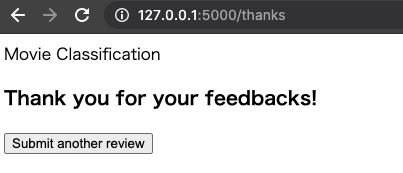

In [15]:
Image('movieclassfier/figure/flask_test4.png')

## PythonAnywhereでのサーバ上でのアプリケーション実行
+ PythonAnywhereとは？
 + PythonベースのWebホスティングサービス。要はサーバを皆さんに貸しますよというサービス。
 + Beginnerアカウントであれば無料である程度のことを扱えるという良心的なサービス。

### PythonAnywhereでの手順  
+  その1： アカウントを作って、python3.8の環境を用意する。
+  その2：virtualenvで自分の環境を作り、sklearn、flask、wtformsをインストールする。
+  その3：ディレクトリを作成し、ファイルをアップロードする。
+  その4：リロードする。

### その1： アカウントを作って、python3.8の環境を用意する。
+ 詳細は教科書に載っているので割愛。

### その2：virtualenvで自分の環境を作り、sklearn、flask、wtformsをインストールする。

Bash consoleを開いて、  
「mkvirtualenv 任意の名前（アルファベット） --python=/usr/bin/python3.8」  
を実行する。  
そのあとは、sklearn、flask、wtformsをインストールをpipを使ってインストールしておく。

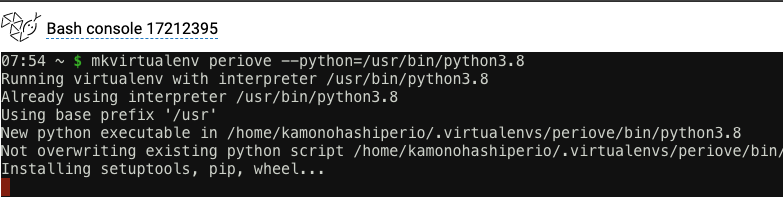

In [19]:
Image('movieclassfier/figure/pythonanywhere_console.png')

管理画面の「Web」からVirtualenvの設定で、先ほど作った環境名を指定する。

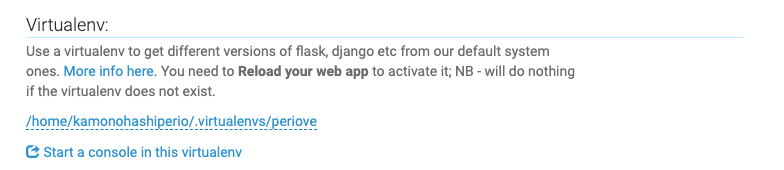

In [17]:
Image('movieclassfier/figure/pythonanywhere_3.png')

管理画面の「Web」で実行するファイルのパスを指定しておく。

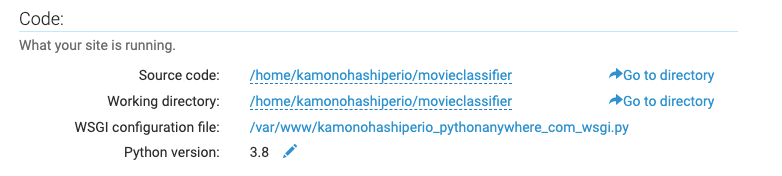

In [26]:
Image('movieclassfier/figure/pythonanywhere_5.png')

### その3：ディレクトリを作成し、ファイルをアップロードする。

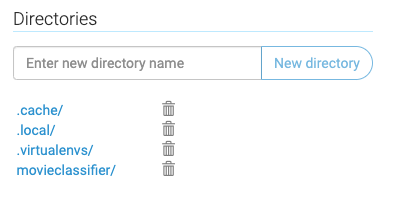

In [11]:
Image('movieclassfier/figure/pythonanywhere_1.png')

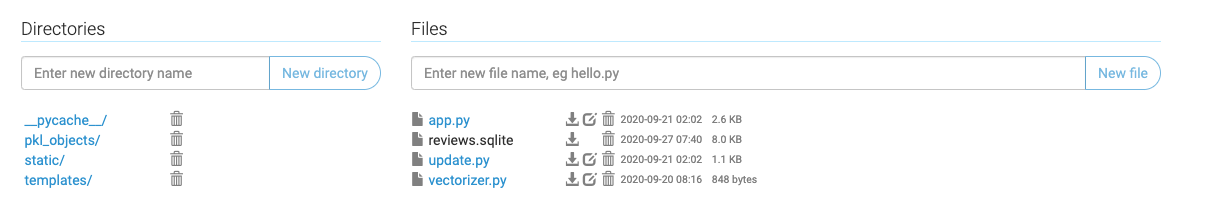

In [16]:
Image('movieclassfier/figure/pythonanywhere_2.png')

### その4：リロードする。

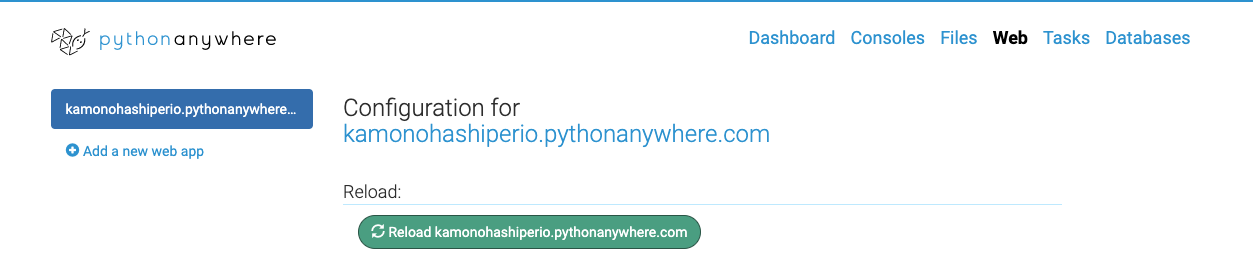

In [18]:
Image('movieclassfier/figure/pythonanywhere_4.png')

### デプロイされたアプリケーションを触ってみる

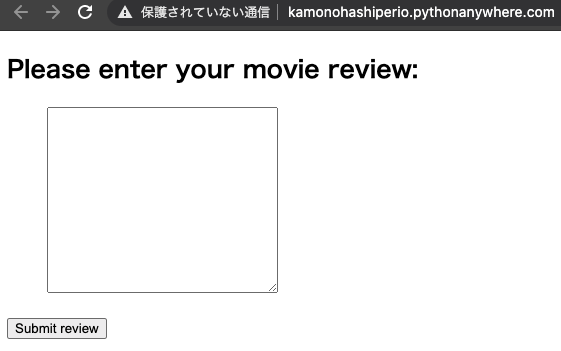

In [20]:
Image('movieclassfier/figure/web_test1.png')

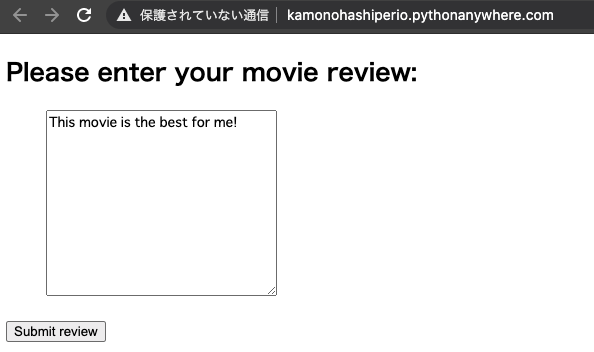

In [21]:
Image('movieclassfier/figure/web_test2.png')

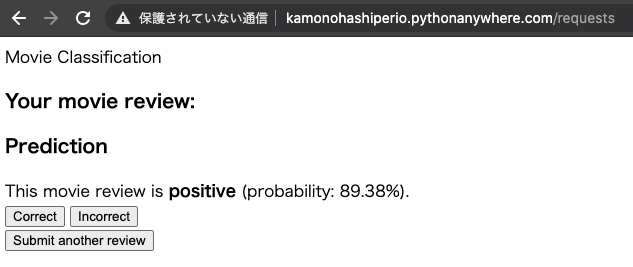

In [22]:
Image('movieclassfier/figure/web_test3.png')

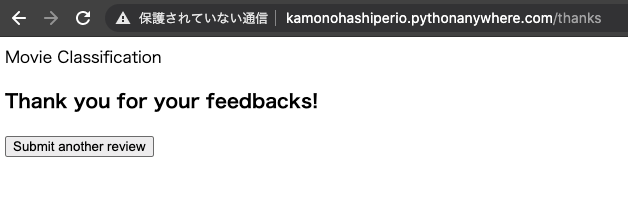

In [23]:
Image('movieclassfier/figure/web_test4.png')

/home/kamonohashiperio/movieclassifier/app.py  

virtualenvでsklearnを入れないと動かない。

mkvirtualenv periove --python=/usr/bin/python3.8

https://www.pythonanywhere.com/forums/topic/14032/